In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import chi2

from itertools import cycle

from prettytable import PrettyTable 

import csv
import os
import sys

(1) Time Series Classification

(1a) AReM Data

https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+%28AReM%29#

Warning: not well formated!
/dataset/bending2/dataset4.csv (not comma seperated!)
/dataset/cycling/dataset14.csv (trailing comma)
/dataset/cycling/dataset9.csv (trailing comma)

Warning: no 480 consecutive values!
/dataset/sitting/dataset8.csv (479 values! missing at 13500)

In [40]:
# return num of files in a given directory
def file_count(dir):
    return len(os.listdir(dir))

# return a list of filename in given directory
def get_filenames(dir):
    return os.listdir(dir)

# rewrite csv to fix any formatting issue (such as trailing comma ...)
def fix_csv(filepath):
    reader_list = []

    with open(filepath, newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[0][0] != '#' and len(row) > 7:
                row.pop(-1)
                assert(len(row) == 7), "ERROR: removing trailing whitespace, comma, etc."
            elif row[0][0] != '#' and len(row) == 1:
                row = row[0].split(' ')
                row.pop(-1)
                assert(len(row) == 7), "ERROR: insert comma"
            reader_list.extend([row])

    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(reader_list)


def find_malformed_csv():
    dirpath = "/Users/ymkim/Desktop/inf552-hw2-workspace/dataset/"
    folders = ["bending1/", "bending2/", "cycling/", "lying/", "sitting/", "standing/", "walking/"]
    folderspath = [dirpath + foldername for foldername in folders]

    malformed_files = []
    for folder in folderspath:
        for filename in get_filenames(folder):
            filepath = folder + filename

            if "csv" in filepath:
                with open(filepath, newline='') as f:
                    reader = csv.reader(f)
                    for row in reader:
                        if row[0][0] != '#' and len(row) != 7:
                            malformed_files.append(filepath)
                            break
    return malformed_files

In [19]:
malformed_files = find_malformed_csv()
for filepath in malformed_files:
    print(filepath)
    fix_csv(filepath)

/Users/ymkim/Desktop/inf552-hw2-workspace/dataset/bending2/dataset4.csv
/Users/ymkim/Desktop/inf552-hw2-workspace/dataset/cycling/dataset14.csv
/Users/ymkim/Desktop/inf552-hw2-workspace/dataset/cycling/dataset9.csv


In [257]:
dirpath = "/Users/ymkim/Desktop/inf552-hw2-workspace/dataset/"
folders = ["bending1/", "bending2/", "cycling/", "lying/", "sitting/", "standing/", "walking/"]
folderspath = [dirpath + foldername for foldername in folders]

# return np array row = 480 x col = 6 for a given dataset
def parse_csv_file(filepath):
    # bypass assert statments (hard-coded!)
    bypassflag = 1
    ignore_dataset = "/Users/ymkim/Desktop/inf552-hw2-workspace/dataset/sitting/dataset8.csv" # only 479 data!!!
    if ignore_dataset == filepath:
        bypassflag = 0

    # meta info for dataset in row 0, 1, 2, 3 (Task, Freq, Clk, Dur) ignore labels!
    df = pd.read_csv(filepath, skiprows=[0,1,2,3])

    if bypassflag:
        assert(len(df) == 480), "ERROR: read csv, invalid rows!"
        assert(len(df.columns) == 7), "ERROR: read csv, invalid cols!"

    col_labels = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    dataset = np.array([df[col] for col in col_labels]).T

    return dataset

# return dataset_dict given main directory of dataset
def get_dataset_dict(dirpath, folders):
    dataset_dict = {} # filepath : np array of dataset
    folderspath = [dirpath + foldername for foldername in folders]

    file_count = 0
    for folder in folderspath:
        for filename in get_filenames(folder):
            filepath = folder + filename
            if "csv" in filepath:
                dataset_dict[filepath] = parse_csv_file(filepath)
                file_count += 1

    assert(file_count == 88), "ERROR: incorrect file count, need 88!"
    return dataset_dict

# return new instance by extracting features given parsed dataset
def extract_instance(dataset):
    # feature extraction (min, max, mean, median, std dev, 1st quartile, 3rd quartile
    minlist = np.amin(dataset, axis = 0) # min1 ... min6
    maxlist = np.amax(dataset, axis = 0) # max1 ... max6
    meanlist = np.mean(dataset, axis=0) # mean1 ... mean6
    medianlist = np.median(dataset, axis = 0) # median1 ... median6
    stdlist = np.std(dataset, axis=0) # std1 ... std6
    q1list = np.percentile(dataset, 25, axis = 0)  # Q1-1 ... Q1-6
    q3list = np.percentile(dataset, 75, axis = 0)  # Q3-1 ... Q3-6

    new_instance = [minlist, maxlist, meanlist,
                    medianlist, stdlist, q1list, q3list]

    size = sum([len(feature) for feature in new_instance])
    assert(size == 42), "ERROR: build new instance, invalid size!"

    # [min1, max1, ... Q1-6, Q3-6]
    return np.reshape(np.array(new_instance), size, order='F')

# return extracted features of a single dataset[i].csv
def get_features(f, ts, dataset):
    ts_feature_dict = {} # ts_id : featureset (min, max, etc.)
    for i in range(len(dataset)):
        ts_id = (i // 7) + 1
        if ts_id in ts_feature_dict:
            ts_feature_dict[ts_id].append(dataset[i])
        else:
            ts_feature_dict[ts_id] = [dataset[i]]

    temp = []
    # select time-series id given in ts
    for i in ts:
        featureset = ts_feature_dict[i]
        # select feature id given in f
        for j in f:
            temp.append(featureset[j])
    return temp

# return evenly split dataset[i].csv
def split_dataset(dataset, size):
    return np.array_split(dataset, size, axis=0)

# given training dataset[i].csv files and its split size, extract new instances on features
# if split_size = 1, extract features (7) on 6 times-series of 480 points,
# result 1 instance each 42 total features for dataset[i].csv
# if split_size = 2, extract features (7) on 12 time-series (6 times-series of 240 points)
# result 2 instance each 42 total features for dataset[i].csv
def build_dataset(train_dataset_dict, split_size=1):
    train_dataset = [] # new instances of dataset[i]
    train_labels = {} # activity : id in train_dataset

    dataset_id = 0
    for filepath, dataset in train_dataset_dict.items():
        # print("extract features from:", filepath)

        temp_dataset = split_dataset(dataset, split_size)
        for dataset in temp_dataset:
            new_instance = extract_instance(dataset)
            train_dataset.append(new_instance)

            label = filepath.split('/')[-2]
            if label in train_labels:
                train_labels[label].append(dataset_id)
            else:
                train_labels[label] = [dataset_id]

            dataset_id += 1

    return train_labels, np.array(train_dataset)

# return training_label np.array where bending 1, other_activity 0 for training_dataset
def build_dataset_labels(train_labels_dict, train_dataset_len):
    train_labelset = []
    for activity, row_list in train_labels_dict.items():
        for i in row_list:
            if 'bending' in activity:
                train_labelset.insert(i,1)
            else:
                train_labelset.insert(i,0)
    
    assert(len(train_labelset) == train_dataset_len), \
        "ERROR: incorrect train_labelset dimension!"
    
    return np.array(train_labelset)

# target_feature(7) [0:min, 1:max, 2:mean, 3:median, 4:std, 5:1Q, 6:3Q]
def build_scatter(train_dataset, train_labels, target_feature=[0,1,2], target_ts=[1,2,6]):
    # build dataset for scatterplot bending vs other activity
    target_feature_label = {0:'min', 1:'max', 2:'mean',
                           3:'median', 4:'std', 5:'1Q', 6:'3Q'}
    bending = {}
    other_activity = {}
    for activity, row in train_labels.items():
        # iterate through dataset[i].csv
        for i in row:
            # get feature id 0, 1, 2 (min, max, mean)
            # from time-series id 1, 2, 6
            for f in target_feature:
                sub_feature = get_features([f], target_ts, train_dataset[i])
                if "bending" in activity:
                    if f in bending:
                        bending[f].extend(sub_feature)
                    else:
                        bending[f] = sub_feature
                else:
                    if f in other_activity:
                        other_activity[f].extend(sub_feature)
                    else:
                        other_activity[f] = sub_feature
    return bending, other_activity

# handler scatterplot for problem 1D bending vs other_activity for time-series 1,2,6 of target_features
def handle_scatterplot_1d(bending, other_activity, target_feature):
    target_feature_label = {0:'min', 1:'max', 2:'mean',
                           3:'median', 4:'std', 5:'1Q', 6:'3Q'}

    fig1 = plt.figure(1, figsize=(14,6))
    p = 1
    for i in range(len(target_feature)):
        temp = target_feature[i:]
        for j in range(len(temp)):
            if target_feature[i] != temp[j]:
                ax = fig1.add_subplot(1,3,p)
                ax.scatter(bending[target_feature[i]], bending[temp[j]],
                           s=3**2, c='r', marker='.', label='Bending')
                ax.scatter(other_activity[target_feature[i]], other_activity[temp[j]],
                           s=3**2, c='b', marker='.', label='Other Activity')
                ax.set_xlabel(target_feature_label[target_feature[i]])
                ax.set_ylabel(target_feature_label[temp[j]])

                if p == 3:
                    # Put a legend to the right of the current axis
                    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                p += 1
    fig1.tight_layout()
    plt.show()
    
# return string label name for a feature given col in dataset
def get_feature_label(col, num_feature=7):
    f_label_dict = {0:'min', 1:'max', 2:'mean',
                 3:'median', 4:'std', 5:'1Q', 6:'3Q'}
    ts_label_dict = {0:'ts1', 1:'ts2', 2:'ts3',
                 3:'ts4', 4:'ts5', 5:'ts6'}

    return f_label_dict[col % num_feature] + "-" + ts_label_dict[col // num_feature]

# return feature col id list based on best time-series split model
# ts_model_feature, ts_model_error results from handle_crossvalidation_1d()
def get_ts_opt_feature(ts_model_feature, ts_model_error):
    # get ts_split val with the highest accuracy
    opt_ts_split = max(ts_model_error, key=ts_model_error.get)
    #print("l:", opt_ts_split, "error[accuracy score]:", ts_model_error[opt_ts_split])

    # get cv model feature, error dict with opt ts_split value
    cv_feature_dict, cv_error_dict = ts_model_feature[opt_ts_split]

    # get cv model with best error
    opt_cv_model = max(cv_error_dict, key= cv_error_dict.get)

    # get feature of the cv model with best error
    opt_feature = cv_feature_dict[opt_cv_model]
    #print("k:", opt_cv_model, "feature:", opt_feature,
    #      "error[accuracy score]:", cv_error_dict[opt_cv_model])

    return {'l': (opt_ts_split, ts_model_error[opt_ts_split]),
            'k': (opt_cv_model, opt_feature, cv_error_dict[opt_cv_model])}
    # return opt_feature

# cross-validate of k=fold = 5 for varying time-series split size l = {1,2 ... 20}
# return model_feature dict and model error dict
def handle_crossvalidation_1d(train_dataset_dict, ts_split_list, feature_size, k_fold=5):
    fs_model_feature = {} # fs : opt_feature

    for fs_split in range(1,feature_size+1,1):
        #print("Feature Reduce:", fs_split)
        ts_model_feature = {} # l : feature tuple ({k: model_features}, {k:error_rates})
        ts_model_error = {} # l : cross validation error rate
        for ts_split in ts_split_list:
            #print("\tTime-Series Split:", ts_split)
            # model to test with different time-series split size
            train_labels_dict, train_dataset = build_dataset(train_dataset_dict, split_size=ts_split)
            train_labelset = build_dataset_labels(train_labels_dict, train_dataset.shape[0])

            # cross valid on the model using Stratified Cross Validation (bending 9 vs other 60)
            skf = StratifiedKFold(n_splits=k_fold)
            skf.get_n_splits(train_dataset, train_labelset)

            error_rates = {}
            model_features = {}
            k = 1
            for train_index, test_index in skf.split(train_dataset, train_labelset):
                #print("\t\tCross-Validation k-fold", k)
                X_train, X_test = train_dataset[train_index], train_dataset[test_index]
                y_train, y_test = train_labelset[train_index], train_labelset[test_index]

                # fit model on k-1 fold training data
                model = LogisticRegression(C=sys.maxsize) # C set to large num, to remove effect of L2 regularization!
                rfe = RFE(model, fs_split)
                rfe = rfe.fit(X_train, y_train)

                # feature selected for model-fit on k-1 training data
                feature_sel = []
                for i in range(X_train.shape[1]):
                    if rfe.support_[i]:
                        feature_sel.append(i)
                model_features[k] = feature_sel

                # test model on validation set
                score = rfe.score(X_test, y_test) # score = 1 is 100% mean accuracy
                error_rates[k] = score

                k += 1

            cv_error_rate = sum(error_rates.values()) / k_fold
            ts_model_error[ts_split] = cv_error_rate
            ts_model_feature[ts_split] = (model_features, error_rates)

        fs_model_feature[fs_split] = get_ts_opt_feature(ts_model_feature, ts_model_error)
    return fs_model_feature


# using PrettyTable package to print Confusion Matrix
def handle_confusionmatrix(tn, fp, fn, tp):
    cm_x_label = ['bending (predicted)', 'other_activity (predicted)']
    cm_y_label = ['','bending (actual)', 'other_activity (actual)']
    cm = PrettyTable(cm_y_label)
    cm.add_row([cm_x_label[0], tp, fp])
    cm.add_row([cm_x_label[1], fn, tn])
    return cm


# similar to handle_crossvalidation_1d(), but uses L1 Logistic Model
# only cross-validates on time-series split l = {1,2 ... 20}
def handle_crossvalidation_1e(train_dataset_dict, ts_split_list, k_fold=5):
    ts_model_error = {} # l : cross validation error rate
    for ts_split in ts_split_list:
        # model to test with different time-series split size
        train_labels_dict, train_dataset = build_dataset(train_dataset_dict, split_size=ts_split)
        train_labelset = build_dataset_labels(train_labels_dict, train_dataset.shape[0])
        
        # cross valid on the model using Stratified Cross Validation (bending 9 vs other 60)
        skf = StratifiedKFold(n_splits=k_fold)
        skf.get_n_splits(train_dataset, train_labelset)

        error_rates = {}
        model_features = {}
        k = 1
        for train_index, test_index in skf.split(train_dataset, train_labelset):
            X_train, X_test = train_dataset[train_index], train_dataset[test_index]
            y_train, y_test = train_labelset[train_index], train_labelset[test_index]

            # fit model on k-1 fold training data
            model = LogisticRegression(penalty='l1', C=1)
            model.fit(X_train, y_train)

            # test model on validation set
            score = model.score(X_test, y_test) # score = 1 is 100% mean accuracy
            error_rates[k] = score
            k += 1

        cv_error_rate = sum(error_rates.values()) / k_fold
        ts_model_error[ts_split] = cv_error_rate

    return ts_model_error


# return muti-class y_label for given train/test_labels_dict
def build_multi_labels(labels_dict):
    le = preprocessing.LabelEncoder()
    le.fit(['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking'])

    label_y = []
    for k, v in labels_dict.items():
        for i in v:
            if 'bending' in k:
                label_y.append('bending')
            else:
                label_y.append(k)
    return le.transform(label_y)

def handle_crossvalidation_1f(model, train_dataset_dict, ts_split_list, k_fold=5):
    ts_model_error = {} # l : cross validation error rate
    for ts_split in ts_split_list:
        # model to test with different time-series split size
        train_labels_dict, train_dataset = build_dataset(train_dataset_dict, split_size=ts_split)
        train_multi_labelset = build_multi_labels(train_labels_dict)
    
        # cross valid on the model using Stratified Cross Validation
        skf = StratifiedKFold(n_splits=k_fold)
        skf.get_n_splits(train_dataset, train_multi_labelset)
    
        error_rates = {}
        k = 1
        for train_index, test_index in skf.split(train_dataset, train_multi_labelset):
            #print("\t\tCross-Validation k-fold", k)
            X_train, X_test = train_dataset[train_index], train_dataset[test_index]
            y_train, y_test = train_multi_labelset[train_index], train_multi_labelset[test_index]
    
            # fit model on k-1 fold training data
            model.fit(X_train, y_train)
    
            # test model on validation set
            score = model.score(X_test, y_test) # score = 1 is 100% mean accuracy
            error_rates[k] = score
    
            k += 1
    
        cv_error_rate = sum(error_rates.values()) / k_fold
        ts_model_error[ts_split] = cv_error_rate
    return ts_model_error

# given y_score from trained model, and y_test labels, plot ROC and AUC
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def handle_roc_1f(n_classes, y_score, y_test):
    str_multi_label = {0:'bending', 1:'cycling', 2:'lying',
                       3:'sitting', 4:'standing', 5:'walking'}

    lw = 2
    colors = cycle(['b', 'g', 'r', 'c', 'm', 'y'])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(str_multi_label[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# given confusion matrix, plot confusion matrix
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix_1f(cm, classes, cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [55]:
# (1b) - Split test and train data
# Test set: 1,2 in folders bending1, bending2 and 1,2,3 in other folders
# Training set: o.w.

dataset_dict = get_dataset_dict(dirpath, folders)
print('total dataset: ', len(dataset_dict))

train_dataset_dict = {}
test_dataset_dict = {}

for folder in folders:
    num_files = file_count(dirpath + folder)
    print("curr folder:", folder, num_files)
    for i in range(num_files):
        filename = dirpath + folder + "dataset{}.csv".format(i+1)
        if folder == 'bending1/' or folder == 'bending2/':
            if i+1 in [1,2]:
                print("\tinserting as test!", filename)
                test_dataset_dict[filename] = dataset_dict[filename]
            else:
                train_dataset_dict[filename] = dataset_dict[filename]
        else:
            if i+1 in [1,2,3]:
                print("\tinserting as test!", filename)
                test_dataset_dict[filename] = dataset_dict[filename]
            else:
                train_dataset_dict[filename] = dataset_dict[filename]

print("size of train:", len(train_dataset_dict))
print("size of test:", len(test_dataset_dict))

assert(len(train_dataset_dict) + len(test_dataset_dict) == len(dataset_dict)), \
    "ERROR: failed to split test, train!"


total dataset:  88
curr folder: bending1/ 7
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/bending1/dataset1.csv
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/bending1/dataset2.csv
curr folder: bending2/ 6
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/bending2/dataset1.csv
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/bending2/dataset2.csv
curr folder: cycling/ 15
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/cycling/dataset1.csv
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/cycling/dataset2.csv
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/cycling/dataset3.csv
curr folder: lying/ 15
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/lying/dataset1.csv
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/dataset/lying/dataset2.csv
	inserting as test! /Users/ymkim/Desktop/inf552-hw2-workspace/da

In [53]:
# (1c - ii) - Feature Extraction (6 time-domain x 7 feature, 88 dataset.csv files)
new_dataset = []
for filepath, dataset in dataset_dict.items():
    new_instance = extract_instance(dataset)
    new_dataset.append(new_instance)

new_dataset = np.array(new_dataset)
print('row:', new_dataset.shape[0])
print('col:', new_dataset.shape[1])
print(new_dataset)

row: 88
col: 42
[[37.25       45.         40.62479167 ...  0.58230797  0.
   1.3       ]
 [38.         45.67       42.8128125  ...  0.60038327  0.
   1.3       ]
 [35.         47.4        43.9545     ...  0.51297092  0.
   0.94      ]
 ...
 [18.33       47.67       34.33304167 ...  1.61560412  2.05
   4.32      ]
 [18.33       45.75       34.599875   ...  1.67841846  2.12
   4.26      ]
 [15.5        43.67       34.225875   ...  1.75931077  2.24
   4.5375    ]]


In [51]:
# (1c - iii) - Std Dev for time-domain features (6 time-domain x 7 feature) and Bootstrap CI of Std Dev
import itertools
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

num_time_series = 6
features = ["min", "max", "mean", "median", "std", "1st-quart", "3rd-quart"]
ts_labels = [str(i+1) for i in range(num_time_series)]
col_labels = [f+ts for f, ts in list(itertools.product(features, ts_labels))]

num_time_domain_features = new_dataset.T.shape[0]

assert(len(col_labels) == num_time_domain_features == 42), \
    "ERROR: Invalid num of time_domain features"

for tf in range(num_time_domain_features):
    samples = new_dataset.T[tf]
    sample_std = np.std(samples, axis=0)
    bs_std = bs.bootstrap(samples, alpha=0.1, stat_func=bs_stats.std)
    print("[{}]: {}, CI({},{})".format(col_labels[tf], sample_std, 
                                              bs_std.lower_bound, bs_std.upper_bound))


[min1]: 9.515445066931841, CI(8.318231177316381,10.804076157155352)
[min2]: 4.36932238296287, CI(3.4829353946475727,5.426723437764975)
[min3]: 5.305314461239687, CI(4.757818806613914,5.920807917940516)
[min4]: 5.409056425357996, CI(4.856829300491787,6.047866924800913)
[min5]: 1.7602191698745813, CI(1.5830945164149417,1.9605092389644692)
[min6]: 6.118526249454473, CI(5.633021019142277,6.69382036229912)
[max1]: 5.109642753365408, CI(4.408307008537643,5.9206804420313)
[max2]: 0.0, CI(0.0,0.0)
[max3]: 5.033881679163113, CI(4.6835303536748984,5.460827143757542)
[max4]: 1.565194252074568, CI(1.43502809936652,1.7438188581526484)
[max5]: 1.4041971241720508, CI(1.273220660847374,1.5779280077434543)
[max6]: 0.8781516314077896, CI(0.8196875463826162,0.9578356818858261)
[mean1]: 0.9409936333203218, CI(0.8532731886175029,1.0573788364277865)
[mean2]: 2.113156527737114, CI(1.9463764339873557,2.3431461939544533)
[mean3]: 2.9396159844182215, CI(2.7851107264269372,3.1358951959090655)
[mean4]: 4.84735791

(1c - iv)

Selecting [min, max, mean] as time-domain features!


row (num of datasets): 69
col (7 features, 6 time series): 42


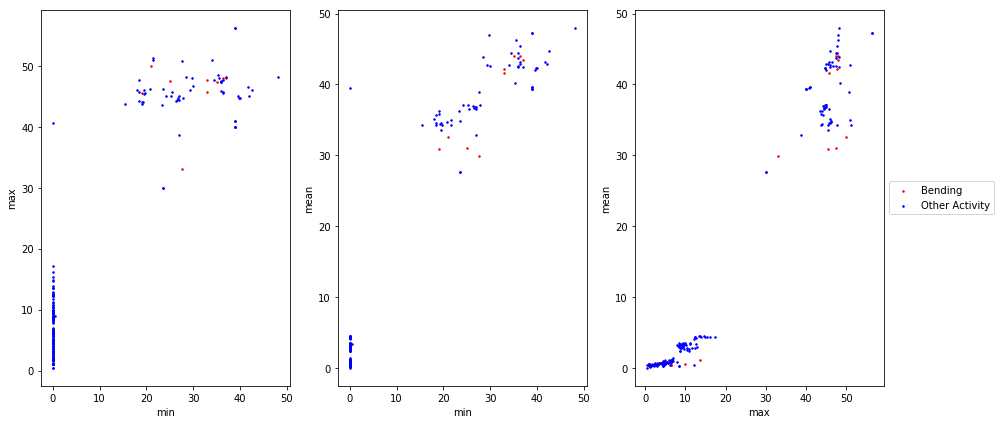

In [124]:
# (1d - i) Scatter Plot - Bending vs Other Activity using Time-Series 1,2,6 and Feature Min, Max, Mean
# Bending (bending1, bending2)
# Other Activity (cycling, lying, sitting, standing, walking)

# build train_dataset of extracted features from train_dataset_dict
train_labels_dict1, train_dataset1 = build_dataset(train_dataset_dict, split_size=1)
print('row (num of datasets):', train_dataset1.shape[0])
print('col (7 features, 6 time series):', train_dataset1.shape[1])

# Scatterplots of [min, max, mean] for time-series 1,2,6 (Training data!)
target_feature = [0,1,2] # target feature (3) min, max, mean
target_time_series = [1,2,6] # from time-series id 1, 2, 6
# build dataset for scatterplot bending vs other activity
bending, other_activity = build_scatter(train_dataset1, train_labels_dict1, target_feature, target_time_series)
handle_scatterplot_1d(bending, other_activity, target_feature)


row (num of datasets): 138
col (7 features, 6 time series): 42


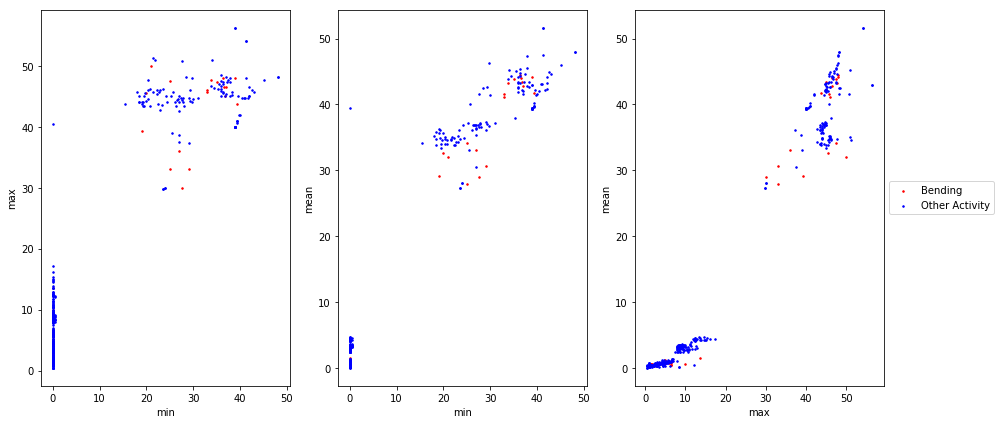

In [125]:
# (1d - ii) Repeat (1d - i) with training set into two equal time series
# dataset[i].csv of 480 (1 instance) is now 240, 240 (2 instance of 6 time-series, 7 features)

# build train_dataset of extracted features from train_dataset_dict
train_labels_dict2, train_dataset2 = build_dataset(train_dataset_dict, split_size=2)
print('row (num of datasets):', train_dataset2.shape[0])
print('col (7 features, 6 time series):', train_dataset2.shape[1])

# Scatterplots of [min, max, mean] for time-series 1,2,6 (Training data!)
target_feature2 = [0,1,2] # target feature (3) min, max, mean
target_time_series2 = [1,2,6] # from time-series id 1, 2, 6
# build dataset for scatterplot bending vs other activity
bending2, other_activity2 = build_scatter(train_dataset2, train_labels_dict2, target_feature2, target_time_series2)
handle_scatterplot_1d(bending2, other_activity2, target_feature2)


In [168]:
# (1d - iii) Logistic Regression, Binary Classification 
# use 5-fold Cross Validation to determine time-series split l = {1,2, ... 20}, feature-reduce size
from time import gmtime, strftime
ts_split_list = np.arange(1,21,1)

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
# cross-validate, train with RFE, Logistic Regression Model (3 attributes)
opt_feature_dict_1d = handle_crossvalidation_1d(train_dataset_dict, ts_split_list, feature_size=42, k_fold=5)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

2018-06-27 12:00:12
2018-06-27 12:26:48


In [308]:
# (1d - iii) cont.
# opt_fs is feature-reduce size of best cv error[ts-split]
# opt_ts is ts-split value of the best cv error
# opt_cv_error is cv error of model ts-split x feature-reduce size 

print("K-Fold Cross Validation (feature, ts split size) Result:")
opt_cv_error_dict_1d = {} # fs : best cv_model[ts-split] error
opt_feature_list_dict_1d = {} # fs :  best feature list of col id
for k, v in opt_feature_dict_1d.items():
    # time-split l, cross-validation error[mean accuracy score]
    # k fold, feature selected, error[mean accuracy score] at fold k
    ts_split, cv_error = v['l']
    kfold, feature_list, kerror = v['k']
    
    # rebuild dict from cv result
    opt_cv_error_dict_1d[k] = cv_error
    opt_feature_list_dict_1d[k] = feature_list

opt_fs_1d = max(opt_cv_error_dict_1d, key=opt_cv_error_dict_1d.get) 
opt_ts_1d = opt_feature_dict_1d[opt_fs_1d]['l'][0] 
opt_cv_error_1d = opt_feature_dict_1d[opt_fs_1d]['l'][1]
opt_feature_1d = opt_feature_list_dict_1d[opt_fs_1d]

print("feature reduce size:", opt_fs_1d, ", time-series split:", opt_ts_1d, ", cv_error:", opt_cv_error_1d)
# print("feature selected: ", opt_feature_1d)
# print([get_feature_label(col) for col in opt_feature_1d])

    
# rebuild classifier with pruned features and opt time-series split 
train_labels_dict, train_dataset = build_dataset(train_dataset_dict, split_size=opt_ts_1d)
train_labelset = build_dataset_labels(train_labels_dict, train_dataset.shape[0])
# new_train_dataset = train_dataset.T[opt_feature_1d].T

print("\nLogistic Model Result:")
model = LogisticRegression(C=1e9) # C set to large num, to remove effect of L2 regularization!
# model.fit(new_train_dataset, train_labelset)
rfe = RFE(model, opt_fs_1d)
rfe = rfe.fit(train_dataset, train_labelset)

feature_sel_1d = []
for i in range(train_dataset.shape[1]):
    if rfe.support_[i]:
        feature_sel_1d.append(i)
opt_feature_1d = [get_feature_label(col) for col in feature_sel_1d]

print('Intercept:', rfe.estimator_.intercept_, 'Coef:', rfe.estimator_.coef_, "\n")
print("feature selected: ", feature_sel_1d, "\n")
print("feature names:", opt_feature_1d, "\n")

# p-values obtain through chi2 (a suggestion from Piazza Class Forum)
r_train_dataset = train_dataset.T[feature_sel_1d].T
chi2_score, pval = chi2(r_train_dataset, train_labelset)
print("p-values:", pval, "\n")

# print('Intercept:', rfe.estimator_.intercept_, 'Coef:', rfe.estimator_.coef_)
print('Training Error[Accuracy Score]:', rfe.score(train_dataset, train_labelset))

K-Fold Cross Validation (feature, ts split size) Result:
feature reduce size: 4 , time-series split: 1 , cv_error: 0.9857142857142858

Logistic Model Result:
Intercept: [-0.36097393] Coef: [[-4.29165372  2.54675766  3.13672461  3.64323038]] 

feature selected:  [6, 28, 29, 33] 

feature names: ['3Q-ts1', 'min-ts5', 'max-ts5', '1Q-ts5'] 

p-values: [3.99688063e-01 2.78982384e-36 3.22181328e-12 3.92403389e-13] 

Training Error[Accuracy Score]: 1.0


(1d - iii) cont.

Instead of using p-values for logistic regressios to prune features, I used 'Recursive Feature Elimination' as shown in the example of the hw assignment. Therefore, the p-values were not calculated. 

The correct way to cross-validate is to include features selection as a part of the process, instead of selecting the features before cross-validation.

Using RFE, Logistic Regression and Stratified Cross-Validation across different time-series split l = {1,2, ... 20} and feature-reduce size = {1,2, ... 42}, the time-series split value of 1 and feature size of 4, gave the best result (0.9857). 

Within the k-fold cross validation model, the model with features that gave the best accuracy is selected. The features selected are col = 6, 28, 29, 33 which are '3Q-ts1', 'min-ts5', 'max-ts5', and '1Q-ts5' respectively.

Confusion Matrix
+----------------------------+------------------+-------------------------+
|                            | bending (actual) | other_activity (actual) |
+----------------------------+------------------+-------------------------+
|    bending (predicted)     |        9         |            0            |
| other_activity (predicted) |        0         |            60           |
+----------------------------+------------------+-------------------------+


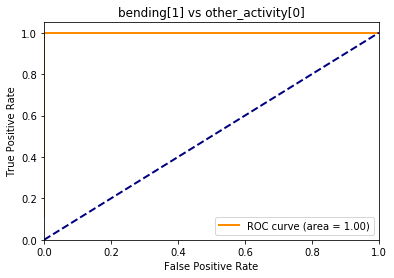

In [218]:
# (1d - iv) - Confusion Matrix and ROC, AUC for classifier

predictions = rfe.predict(train_dataset)
tn, fp, fn, tp = metrics.confusion_matrix(train_labelset, predictions).ravel()
print('Confusion Matrix')
print(handle_confusionmatrix(tn, fp, fn, tp))

# Compute ROC curve and ROC area
y_score = rfe.decision_function(train_dataset)
fpr, tpr, thresholds = metrics.roc_curve(train_labelset, y_score)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('bending[1] vs other_activity[0]')
plt.legend(loc="lower right")
plt.show()


(1d - iv) cont. 

Parameters of Logistic Regression
Intercept: [-0.36097393] = B0
Coef: [-4.29165372, 2.54675766, 3.13672461, 3.64323038] = B1, B2, B3, B4, corresponding to 3Q-ts1, min-ts5, max-ts5, 1Q-ts5, respectively.

I have tried to used statsmodels.api packaget to perform Logistic Regression in order to obtain statistics, such as p-values, but was unable to obtain them due to "Perfect Separation Error." I have tried to lower the default 'maxiter' from 35 to a lower value, but it would result in "Singular Matrix Error." A suggestion provided in Piazza Forum was to use chi2 test to obtain p-vaues for the features selected.

The p-values results: [3.99688063e-01, 2.78982384e-36, 3.22181328e-12, 3.92403389e-13] 


In [298]:
# (1d - v) Test the classifier on test dataset

# build test dataset
test_labels_dict, test_dataset = build_dataset(test_dataset_dict, split_size=opt_ts_1d)
test_labelset = build_dataset_labels(test_labels_dict, test_dataset.shape[0])
# prune out the features based on cv results
# new_test_dataset = test_dataset.T[opt_feature_1d].T

# rfe model pruned out the features
print("Logistic Model Result: Test Set")
print('Training Score:', rfe.score(train_dataset, train_labelset))
print('Test Score:', rfe.score(test_dataset, test_labelset))

Logistic Model Result: Test Set
Training Score: 1.0
Test Score: 1.0


(1d - vi) - Classes well-seperated

import statsmodels.api as sm <br>
logit = sm.Logit(train_labelset, sm.add_constant(train_dataset)) <br>
result = logit.fit(maxiter=30) # reduce maxiter default 35 to lower value according tof footnote 4 <br>
print(result.summary()) <br>


Yes. The class is either 1 or 0, where 1 defined as 'bending' and 0 is defined as 'other_activity'. When using stasmodels.api package (logit = sm.Logit(y, X)) to calculate the logic regression parameters (coefficent values, p-values), it results in error with "PerfectSeparationError: Perfect separation detected, results not available." Additionally, looking at the confusion matrix, the results indicate that the fitted model is able to clearly distinguish between class 1 and 0. 

(1d - vii)

From the confusion matrix above in (1d - iv), we see that the classifier we trained is able to accurately predict the positive and negative class with out errors. The Training and Test Score are both 1. Even though the trained model is able to correctly identify the class, the 'other_activity' class(60) is predominant over 'bending' class(9). 

I have adjusted the parameters using time-series split and features reduced from cross-validation results. Then, used SMOTE method to improve the class imbalance of bending vs other_activity to (60, 60). From the results below, both train and test accuracy score are of value 1.

Class Imbalance - Using SMOTE
Training Score: 1.0
Test Score: 1.0

Confusion Matrix
+----------------------------+------------------+-------------------------+
|                            | bending (actual) | other_activity (actual) |
+----------------------------+------------------+-------------------------+
|    bending (predicted)     |        60        |            0            |
| other_activity (predicted) |        0         |            60           |
+----------------------------+------------------+-------------------------+


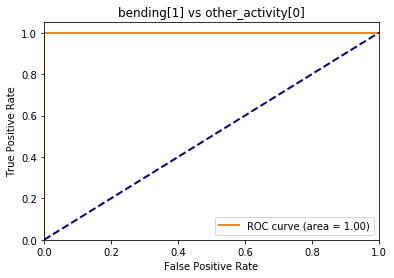

In [300]:
# (1d - vii) cont. Using SMOTE to balance out rare class 9 vs 60
# use opt_ts and opt_feature determined from CV result

from imblearn.over_sampling import SMOTE
method = SMOTE(kind='regular')
x_res, y_res = method.fit_sample(train_dataset, train_labelset)

new_x_res = x_res.T[feature_sel_1d].T
logreg = LogisticRegression(C=1e9)
logreg.fit(new_x_res, y_res)

print("Class Imbalance - Using SMOTE")
print('Training Score:', logreg.score(new_x_res, y_res))
print('Test Score:', logreg.score(test_dataset.T[feature_sel_1d].T, test_labelset))

predictions = logreg.predict(new_x_res)
tn, fp, fn, tp = metrics.confusion_matrix(y_res, predictions).ravel()
print('\nConfusion Matrix')
print(handle_confusionmatrix(tn, fp, fn, tp))

# Compute ROC curve and ROC area
y_score = logreg.decision_function(new_x_res)
fpr, tpr, thresholds = metrics.roc_curve(y_res, y_score)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('bending[1] vs other_activity[0]')
plt.legend(loc="lower right")
plt.show()

In [236]:
# (1e - i) Binary Classification using L1-penalized logistic regression

# cross-validate on different time-series split l = {1,2 ... 20}
ts_split_list = np.arange(1,21,1)
ts_model_error_1e = handle_crossvalidation_1e(train_dataset_dict, ts_split_list)


In [310]:
# (1e - i) cont.
print("K-Fold Cross Validation (ts split size) using L1 Regularization Result:")
opt_ts_1e = max(ts_model_error_1e, key=ts_model_error_1f.get)
opt_cv_error_1e = ts_model_error_1e[opt_ts_1e]

print("time-series split:", opt_ts_1e, ", cv_error:", opt_cv_error_1e)

# rebuild L1 classifier with opt time-series split 
train_labels_dict, train_dataset = build_dataset(train_dataset_dict, split_size=opt_ts_1e)
train_labelset = build_dataset_labels(train_labels_dict, train_dataset.shape[0])

model_1e = LogisticRegression(penalty='l1', C=1)
model_1e.fit(train_dataset, train_labelset)

print("\nLogistic L1 Model Result:")
coef_sel_1e = []
feature_sel_1e = []
for i in range(len(model_1e.coef_[0])):
    if model_1e.coef_[0][i] != 0:
        feature_sel_1e.append(i)
        coef_sel_1e.append(model_1e.coef_[0][i])
opt_feature_1e = [get_feature_label(col) for col in feature_sel_1e]

print('Intercept:', model_1e.intercept_, 'Coef:', coef_sel_1e, "\n")
print("feature selected: ", feature_sel_1e, "\n")
print("feature names:", opt_feature_1e, "\n")

# p-values obtain through chi2 (a suggestion from Piazza Class Forum)
r_train_dataset = train_dataset.T[feature_sel_1e].T
chi2_score, pval = chi2(r_train_dataset, train_labelset)
print("p-values:", pval, "\n")

# build test dataset
test_labels_dict, test_dataset = build_dataset(test_dataset_dict, split_size=opt_ts_1e)
test_labelset = build_dataset_labels(test_labels_dict, test_dataset.shape[0])

print("L1 Result:")
print('Training Error[Accuracy Score]:', model_1e.score(train_dataset, train_labelset))
print('Test Score[Accuracy Score]:', model_1e.score(test_dataset, test_labelset))

K-Fold Cross Validation (ts split size) using L1 Regularization Result:
time-series split: 1 , cv_error: 0.9714285714285715

Logistic L1 Model Result:
Intercept: [0.] Coef: [-0.0831758771030988, -0.08564204223550195, -0.3899424766990539, -0.3850633838881327, 0.4450890924340577, 0.5832979425394517, 0.2019650876993254] 

feature selected:  [2, 5, 6, 8, 28, 29, 33] 

feature names: ['mean-ts1', '1Q-ts1', '3Q-ts1', 'max-ts2', 'min-ts5', 'max-ts5', '1Q-ts5'] 

p-values: [5.16023273e-01 4.12325102e-01 3.99688063e-01 1.20981026e-03
 2.78982384e-36 3.22181328e-12 3.92403389e-13] 

L1 Result:
Training Error[Accuracy Score]: 1.0
Test Score[Accuracy Score]: 1.0


(1e - ii) L1-penalized vs variable selection (RFE)

In both cases, the the test and training error (accuracy score = 1) results are equivalent. They equally performed well. When performing cross-validation on the time-series split value, both resulted in 1, meaning (no splits). The difference was the number of the features that were selected and reduced. Using L1-penalty for Logistic Regression, it resulted in 7 features (mean-ts1, 1Q-ts1, 3Q-ts1, max-ts2, min-ts5, max-ts5, 1Q-ts5). On the otherhand, RFE resulted in 4 features (3Q-ts1, min-ts5, max-ts5, 1Q-ts5). 

L1-penalty Logistic Regression was easier to validate because there was no need to cross-validate on the number of features to reduce for RFE Model. L1-penalization will force irrelevant feature/coefficent values to 0.


In [255]:
# (1f - i) Multi-Class, L1 Multinominal Regression

ts_split_list = np.arange(1,21,1)
classifier_1f = LogisticRegression(penalty='l1', C=1, multi_class='ovr')
ts_model_error_1f = handle_crossvalidation_1f(classifier_1f, train_dataset_dict, ts_split_list)


K-Fold Cross Validation L1, Multinomial Regression Result:
time-series split: 1 , cv_error: 0.8729946524064172
Train Score: 0.9855072463768116
Test Score: 0.8421052631578947

Confusion Matrix 1F


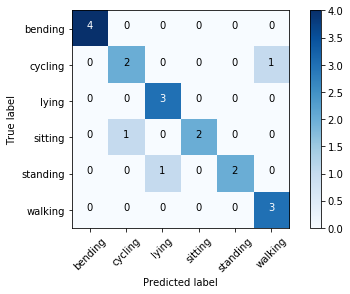


ROC/AUC Plot 1F


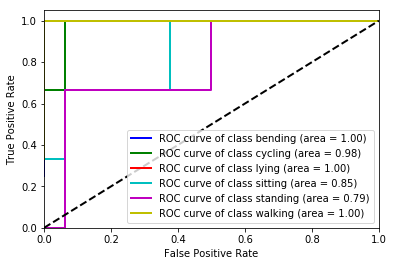

In [311]:
# (1f - i) cont.
print("K-Fold Cross Validation L1, Multinomial Regression Result:")
opt_ts_1f = max(ts_model_error_1f, key=ts_model_error_1f.get)
print("time-series split:", opt_ts_1f, ", cv_error:", ts_model_error_1f[opt_ts_1f])

train_labels_dict, train_dataset = build_dataset(train_dataset_dict, split_size=opt_ts_split_1f)
test_labels_dict, test_dataset = build_dataset(test_dataset_dict, split_size=opt_ts_split_1f)
train_multi_labelset = build_multi_labels(train_labels_dict)
test_multi_labelset = build_multi_labels(test_labels_dict)

classifier_1f = LogisticRegression(penalty='l1', C=1, multi_class='ovr')
classifier_1f = classifier_1f.fit(train_dataset, train_multi_labelset)

print("Train Score:", classifier_1f.score(train_dataset, train_multi_labelset))
print("Test Score:", classifier_1f.score(test_dataset, test_multi_labelset))

# Confusion Matrix 1F Multinomial Regression
print("\nConfusion Matrix 1F")
y_pred = classifier_1f.predict(test_dataset)
cnf_matrix = metrics.confusion_matrix(test_multi_labelset, y_pred)
# print(cnf_matrix)
class_names = ['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']
plot_confusion_matrix_1f(cnf_matrix, classes=class_names)

# ROC/AUC 1F Multinomial Regression
print("\nROC/AUC Plot 1F")
y_test = label_binarize(test_multi_labelset, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test.shape[1]
y_score = classifier_1f.decision_function(test_dataset)
handle_roc_1f(n_classes, y_score, y_test)

In [262]:
# (1f - ii) Naive Bayes Classifier, Gaussian and Multinomial priors

ts_split_list = np.arange(1,21,1)

# Cross-Validate on Time-series split for Naive Bayes, Gaussian
classifier_1f_gnb = GaussianNB()
ts_model_error_1f_gnb = handle_crossvalidation_1f(classifier_1f_gnb, train_dataset_dict, ts_split_list)

# Cross-Validate on Time-series split for Naive Bayes, Multinnomial
classifier_1f_mnb = MultinomialNB()
ts_model_error_1f_mnb = handle_crossvalidation_1f(classifier_1f_mnb, train_dataset_dict, ts_split_list)


K-Fold Cross Validation (Time-Series l) Naive Bayes Gaussian Result:
time-series split: 2 , cv_error: 0.8970657528378668
Train Score: 0.9492753623188406
Test Score: 0.8947368421052632

Confusion Matrix 1F - NB Gaussian


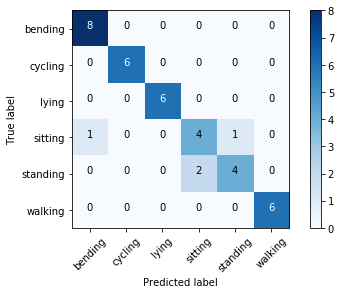


ROC/AUC Plot 1F - NB Gaussian


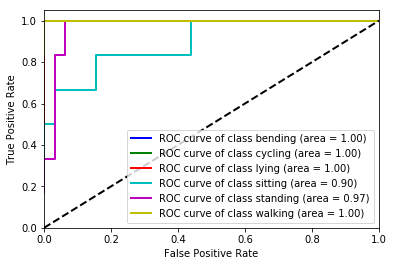

In [287]:
# (1f - ii) cont.
print("K-Fold Cross Validation (Time-Series l) Naive Bayes Gaussian Result:")
opt_ts_1f_gnb = max(ts_model_error_1f_gnb, key=ts_model_error_1f_gnb.get)
print("time-series split:", opt_ts_1f_gnb, ", cv_error:", ts_model_error_1f_gnb[opt_ts_1f_gnb])

train_labels_dict, train_dataset = build_dataset(train_dataset_dict, split_size=opt_ts_1f_gnb)
test_labels_dict, test_dataset = build_dataset(test_dataset_dict, split_size=opt_ts_1f_gnb)
train_multi_labelset = build_multi_labels(train_labels_dict)
test_multi_labelset = build_multi_labels(test_labels_dict)

classifier_1f_gnb = GaussianNB()
classifier_1f_gnb = classifier_1f_gnb.fit(train_dataset, train_multi_labelset)

print("Train Score:", classifier_1f_gnb.score(train_dataset, train_multi_labelset))
print("Test Score:", classifier_1f_gnb.score(test_dataset, test_multi_labelset))

# Confusion Matrix 1F
print("\nConfusion Matrix 1F - NB Gaussian")
y_pred = classifier_1f_gnb.predict(test_dataset)
cnf_matrix = metrics.confusion_matrix(test_multi_labelset, y_pred)
class_names = ['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']
plot_confusion_matrix_1f(cnf_matrix, classes=class_names)

# ROC/AUC 1F Multinomial
print("\nROC/AUC Plot 1F - NB Gaussian")
y_test = label_binarize(test_multi_labelset, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test.shape[1]
y_score = classifier_1f_gnb.predict_proba(test_dataset) # Target scores, probability estimates
handle_roc_1f(n_classes, y_score, y_test)


K-Fold Cross Validation (Time-Series l) Naive Bayes Multinomial Result:
time-series split: 1 , cv_error: 0.8381461675579323
Train Score: 0.927536231884058
Test Score: 0.8947368421052632

Confusion Matrix 1F - NB Multinomial


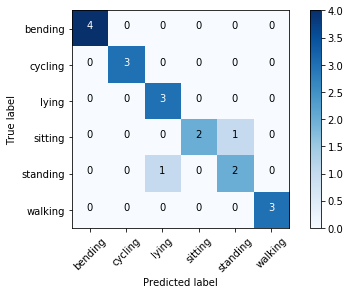


ROC/AUC Plot 1F - NB Multinomial


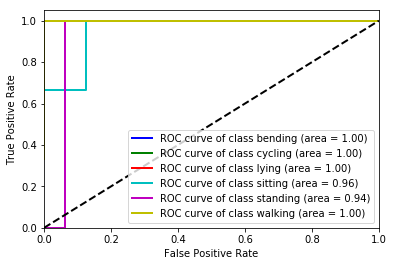

In [312]:
# (1f - ii) cont.
print("K-Fold Cross Validation (Time-Series l) Naive Bayes Multinomial Result:")
opt_ts_1f_mnb = max(ts_model_error_1f_mnb, key=ts_model_error_1f_mnb.get)
print("time-series split:", opt_ts_1f_mnb, ", cv_error:", ts_model_error_1f_mnb[opt_ts_1f_mnb])

train_labels_dict, train_dataset = build_dataset(train_dataset_dict, split_size=opt_ts_1f_mnb)
test_labels_dict, test_dataset = build_dataset(test_dataset_dict, split_size=opt_ts_1f_mnb)
train_multi_labelset = build_multi_labels(train_labels_dict)
test_multi_labelset = build_multi_labels(test_labels_dict)

classifier_1f_mnb = MultinomialNB()
classifier_1f_mnb = classifier_1f_mnb.fit(train_dataset, train_multi_labelset)

print("Train Score:", classifier_1f_mnb.score(train_dataset, train_multi_labelset))
print("Test Score:", classifier_1f_mnb.score(test_dataset, test_multi_labelset))

# Confusion Matrix 1F
print("\nConfusion Matrix 1F - NB Multinomial")
y_pred = classifier_1f_mnb.predict(test_dataset)
cnf_matrix = metrics.confusion_matrix(test_multi_labelset, y_pred)
class_names = ['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']
plot_confusion_matrix_1f(cnf_matrix, classes=class_names)

# ROC/AUC 1F Multinomial
print("\nROC/AUC Plot 1F - NB Multinomial")
y_test = label_binarize(test_multi_labelset, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test.shape[1]
y_score = classifier_1f_mnb.predict_proba(test_dataset) # Target scores, probability estimates
handle_roc_1f(n_classes, y_score, y_test)

(1f - ii) Compare Naive Bayes Gaussian and Multinomial

Comparing Naive Bayes Gaussian and Multinomial priors, the cross-validation results indicate the best time-series splits are 2 and 1, respectively. The training scores were better for Gaussian (0.949) compared to that of Multinomial (0.927); however the test scores (0.894) for both were equivalent. 

(1f - iii)

Based on the test data scores for Gaussian and Multinomial Priors, the results were equivalent (0.894). Based on this dataset, the Multi-Class Classification, they equally performed well. 


(2) ISLR 3.7.4

a. The training RSS for cubic regression will be lower than that of linear regression. Since its cubic, it will try to fit as close to the training data as possible.

b. The test RSS for cubic regression will be higher than the test RSS for linear regression. Since the true relationship is linear, we are overfitting with a cubic model, resulting in a higher test error.

c. The training RSS for cubic regression will be lower than the training Rss for linear model. Cubic regression is more complex model than that of linear regression, so it will closely fit to the given training data, thus resulting in a lower RSS regardless of the underlying true model. 

d. Since we do not know the true relationship of how from linear the model is, not enough information is given to determine whether cubic or linear will have the better test RSS.

(3) ISLR 4.7.3

see screenshot attachment

(4) ISLR 4.7.7

see screenshot attachment